# Machine Learning

In this project I try to predict traffic speed in Ho Chi Minh City using various machine learning models. I tried to combine both regression and classification

#### Regression as the Core Model

- Use it to predict continuous speed.

- Necessary if you want to calculate travel time.

#### Classification as a Presentation Layer

- Convert predicted speed into traffic states:

0–20 km/h → Slow

20–30 km/h → Medium

more 30 km/h → Fast

- Useful for visual dashboards or alerts (e.g., “Warning: Heavy Traffic in District 1”).

=> This way, I get the accuracy of regression + the clarity of classification.

### I. Import Libraries

In [11]:
# Import libraries
import numpy as np
import pandas as pd
import requests
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import json


from pytz import timezone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR , SVC
import matplotlib.pyplot as plt

%matplotlib inline 

print("Library verions:")
print("- numpy:", np.__version__)
print("- pandas:", pd.__version__)
print("- requests:", requests.__version__)
print("- sklearn:", sklearn.__version__)
print("- seaborn:", sns.__version__)

Library verions:
- numpy: 2.2.0
- pandas: 2.3.2
- requests: 2.32.5
- sklearn: 1.7.2
- seaborn: 0.13.2


### II. Data Collection & Processing

In [12]:
# Set API key (for traffic data and weather data)
TOMTOM_API_KEY = os.environ.get("TOMTOM_API_KEY")
OPENWEATHER_API_KEY = os.environ.get("OPENWEATHER_API_KEY")
# Coordinates for key locations (latitude, longitude) in HCMC
hcmc_locations = {
    "District_1": {"lat": 10.7757, "lon": 106.7009},
    "Thu_Thiem": {"lat": 10.7835, "lon": 106.7215},
    "Tan_Son_Nhat": {"lat": 10.8181, "lon": 106.6519},
    "Binh_Thanh": {"lat": 10.8106, "lon": 106.7091},
    "Phu_My_Hung": {"lat": 10.7272, "lon": 106.7057}
}

hcmc_tz = timezone("Asia/Ho_Chi_Minh")

# Set time range for data generation
start_date = datetime(2025, 9, 20, 22, 0, 0, tzinfo=hcmc_tz) 
end_date = datetime(2025, 9, 30, 0, 0, 0, tzinfo=hcmc_tz)
# end_date = datetime.now(hcmc_tz) 

# Generate list of hourly timestamps
timestamps = []
current_time = start_date
while current_time <= end_date:
    timestamps.append(current_time)
    current_time += timedelta(hours=1)

print("HCMC Timezone:", hcmc_tz)
print("Start date (HCMC):", start_date.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
print("End date (HCMC):", end_date.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
print(f"Collecting data for {len(timestamps)} hourly intervals...")

HCMC Timezone: Asia/Ho_Chi_Minh
Start date (HCMC): 2025-09-20 22:00:00 LMT+0707
End date (HCMC): 2025-09-30 00:00:00 LMT+0707


In [13]:
# Function to get traffic data from TomTom API
def get_traffic_data(lat, lon, api_key, timestamp):
    url = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
    params = {
        'point': f"{lat},{lon}",
        'unit': 'KMPH',
        'key': api_key,
        'zoom': 12
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching traffic data for {lat},{lon} at {timestamp}: {e}")
        return None

# Function to get weather data from OpenWeatherMap API
def get_weather_data(lat, lon, api_key, timestamp):
    url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': 'metric'
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching weather data for {lat},{lon} at {timestamp}: {e}")
        return None


### III. Process and merge datasets (weather and traffic data)

In [14]:
# Function to process traffic data
def process_traffic_data(traffic_data_dict, location_name, timestamp):
    processed_data = []
    if traffic_data_dict and 'flowSegmentData' in traffic_data_dict:
        segment = traffic_data_dict['flowSegmentData']
        processed_data.append({
            'Location': location_name,
            'Timestamp': timestamp,
            'Current_Speed': segment.get('currentSpeed', 0),
            'Free_Flow_Speed': segment.get('freeFlowSpeed', 0),
            'Confidence': segment.get('confidence', 0),
            'Congestion_Level': segment.get('currentTravelTime', 0) / segment.get('freeFlowTravelTime', 1) * 100,
            'Road_Closure': segment.get('roadClosure', False)
        })
    return processed_data

# Function to process weather data
def process_weather_data(weather_data_dict, timestamp):
    if weather_data_dict and 'main' in weather_data_dict:
        return {
            'Timestamp': timestamp,
            'Temperature': weather_data_dict['main'].get('temp', 0),
            'Humidity': weather_data_dict['main'].get('humidity', 0),
            'Wind_Speed': weather_data_dict['wind'].get('speed', 0) if 'wind' in weather_data_dict else 0,
            'Rainfall': weather_data_dict['rain']['1h'] if 'rain' in weather_data_dict and '1h' in weather_data_dict['rain'] else 0
        }
    return None

# Collect and process data for each hour
all_traffic_data = []
all_weather_data = []

for timestamp in timestamps:
    print(f"\nCollecting data for {timestamp.strftime('%Y-%m-%d %H:%M:%S %Z')}...")
    
    # Collect traffic data
    traffic_data = {}
    for name, coords in hcmc_locations.items():
        # print(f"Fetching traffic data for {name}...")
        data = get_traffic_data(coords["lat"], coords["lon"], TOMTOM_API_KEY, timestamp)
        if data:
            traffic_data[name] = data
        time.sleep(1) 
    
    # Collect weather data
    weather_data = {}
    for name, coords in hcmc_locations.items():
        # print(f"Fetching weather data for {name}...")
        data = get_weather_data(coords["lat"], coords["lon"], OPENWEATHER_API_KEY, timestamp)
        if data:
            weather_data[name] = data
        time.sleep(1) 
    
    # Process traffic data
    for name, data in traffic_data.items():
        processed_traffic = process_traffic_data(data, name, timestamp)
        all_traffic_data.extend(processed_traffic)
    
    # Process weather data
    for name, data in weather_data.items():
        processed_weather = process_weather_data(data, timestamp)
        if processed_weather:
            processed_weather['Location'] = name
            all_weather_data.append(processed_weather)

# Create DataFrames
traffic_df = pd.DataFrame(all_traffic_data)
weather_df = pd.DataFrame(all_weather_data)

# Merge datasets on Timestamp and Location
if not traffic_df.empty and not weather_df.empty:
    merged_df = pd.merge(
        traffic_df,
        weather_df,
        on=['Timestamp', 'Location'],
        how='left'
    )
else:
    merged_df = traffic_df if not traffic_df.empty else weather_df

# Add time-based features
if not merged_df.empty:
    merged_df['Hour'] = merged_df['Timestamp'].dt.hour
    merged_df['Month'] = merged_df['Timestamp'].dt.month
    merged_df['Day_of_Week'] = merged_df['Timestamp'].dt.dayofweek
    merged_df['Is_Weekend'] = (merged_df['Day_of_Week'] >= 5).astype(int)
    merged_df['Is_Rush_Hour'] = (
        ((merged_df['Hour'] >= 7) & (merged_df['Hour'] <= 9)) |
        ((merged_df['Hour'] >= 16) & (merged_df['Hour'] <= 19))
    ).astype(int)

# Display the data
print("\nFull Hourly Data:")
print(merged_df.to_string(index=False))
merged_df.sample(15)





























































































































































































































Full Hourly Data:
    Location                 Timestamp  Current_Speed  Free_Flow_Speed  Confidence  Congestion_Level  Road_Closure  Temperature  Humidity  Wind_Speed  Rainfall  Hour  Month  Day_of_Week  Is_Weekend  Is_Rush_Hour
  District_1 2025-09-20 21:53:00+07:00             15               25           1        166.666667         False        30.53        72        3.09         0    21      9            5           1             0
   Thu_Thiem 2025-09-20 21:53:00+07:00             40               40           1        100.000000         False        31.16        71        2.24         0    21      9            5           1             0
Tan_Son_Nhat 2025-09-20 21:53:00+07:00             31               31           1        100.000000         False        32.0

,Location,Timestamp,Current_Speed,Free_Flow_Speed,Confidence,Congestion_Level,Road_Closure,Temperature,Humidity,Wind_Speed,Rainfall,Hour,Month,Day_of_Week,Is_Weekend,Is_Rush_Hour
591,Thu_Thiem,2025-09-25 19:53:00+07:00,40,40,1,100.000000,False,31.72,70,3.60,0,19,9,3,0,1
901,Thu_Thiem,2025-09-28 09:53:00+07:00,40,40,1,100.000000,False,31.16,72,3.60,0,9,9,6,1,1
194,Phu_My_Hung,2025-09-22 11:53:00+07:00,34,41,1,120.604703,False,31.73,70,1.79,0,11,9,0,0,0
509,Phu_My_Hung,2025-09-25 02:53:00+07:00,33,42,1,127.293578,False,31.73,69,1.54,0,2,9,3,0,0
393,Binh_Thanh,2025-09-24 03:53:00+07:00,24,33,1,137.563452,False,31.72,69,1.54,0,3,9,2,0,0
933,Binh_Thanh,2025-09-28 15:53:00+07:00,22,32,1,145.812808,False,31.16,73,3.60,0,15,9,6,1,0
542,Tan_Son_Nhat,2025-09-25 09:53:00+07:00,31,31,1,100.000000,False,32.01,62,1.54,0,9,9,3,0,1
691,Thu_Thiem,2025-09-26 15:53:00+07:00,40,40,1,100.000000,False,31.72,70,3.60,0,15,9,4,0,0
582,Tan_Son_Nhat,2025-09-25 17:53:00+07:00,31,31,1,100.000000,False,32.01,62,3.60,0,17,9,3,0,1
414,Phu_My_Hung,2025-09-24 07:53:00+07:00,33,41,1,124.300112,False,31.73,69,1.54,0,7,9,2,0,1


In [15]:
# Save merged dataset to CSV
print("Saving processed data to CSV...")
output_file = "traffic_weather_data.csv"
merged_df.to_csv(output_file, index=False)
print(f"\nDataset saved to {output_file}")

Saving processed data to CSV...

Dataset saved to traffic_weather_data.csv


In [16]:
# Load dataset from CSV
input_file = "traffic_weather_data.csv"
merged_df = pd.read_csv(input_file)
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

print("\nLoaded Data Sample:")
print(merged_df.sample(15).to_string(index=False))


Loaded Data Sample:
    Location                 Timestamp  Current_Speed  Free_Flow_Speed  Confidence  Congestion_Level  Road_Closure  Temperature  Humidity  Wind_Speed  Rainfall  Hour  Month  Day_of_Week  Is_Weekend  Is_Rush_Hour
 Phu_My_Hung 2025-09-25 06:53:00+07:00             33               42           1        127.293578         False        31.73        69        1.54         0     6      9            3           0             0
 Phu_My_Hung 2025-09-22 06:53:00+07:00             33               41           1        124.300112         False        31.73        70        1.79         0     6      9            0           0             0
  District_1 2025-09-26 16:53:00+07:00              6               24           1        402.941176         False        31.66        70        3.60         0    16      9            4           0             1
 Phu_My_Hung 2025-09-25 18:53:00+07:00             35               41           1        117.133259         False        31.73    

### IV. Data Quality Check (Missing values/ Noisy values)

In [17]:
df_cleaned = merged_df.dropna() 
df_cleaned = df_cleaned[df_cleaned['Free_Flow_Speed'] > 0]  
df_cleaned.reset_index(drop=True, inplace=True) 
print("\nCleaned Data:")      
print(df_cleaned.to_string(index=False))

# Display cleaned data
mean_impute_values = {
    'Current_Speed': df_cleaned['Current_Speed'].mean(),    
    'Free_Flow_Speed': df_cleaned['Free_Flow_Speed'].mean(),
    'Confidence': df_cleaned['Confidence'].mean(),
    'Congestion_Level': df_cleaned['Congestion_Level'].mean(),
    'Temperature': df_cleaned['Temperature'].mean(),
    'Humidity': df_cleaned['Humidity'].mean(),
    'Wind_Speed': df_cleaned['Wind_Speed'].mean(),
    'Rainfall': df_cleaned['Rainfall'].mean()
}
print ("\nMean Imputation Values:")
print(mean_impute_values) 

median_impute_values = {
    'Current_Speed': df_cleaned['Current_Speed'].median(),    
    'Free_Flow_Speed': df_cleaned['Free_Flow_Speed'].median(),
    'Confidence': df_cleaned['Confidence'].median(),
    'Congestion_Level': df_cleaned['Congestion_Level'].median(),
    'Temperature': df_cleaned['Temperature'].median(),
    'Humidity': df_cleaned['Humidity'].median(),
    'Wind_Speed': df_cleaned['Wind_Speed'].median(),
    'Rainfall': df_cleaned['Rainfall'].median()
}
print ("\nMedian Imputation Values:")
print(median_impute_values)




Cleaned Data:
    Location                 Timestamp  Current_Speed  Free_Flow_Speed  Confidence  Congestion_Level  Road_Closure  Temperature  Humidity  Wind_Speed  Rainfall  Hour  Month  Day_of_Week  Is_Weekend  Is_Rush_Hour
  District_1 2025-09-20 21:53:00+07:00             15               25           1        166.666667         False        30.53        72        3.09         0    21      9            5           1             0
   Thu_Thiem 2025-09-20 21:53:00+07:00             40               40           1        100.000000         False        31.16        71        2.24         0    21      9            5           1             0
Tan_Son_Nhat 2025-09-20 21:53:00+07:00             31               31           1        100.000000         False        32.01        62        2.24         0    21      9            5           1             0
  Binh_Thanh 2025-09-20 21:53:00+07:00             22               33           1        150.253807         False        31.16        71

### V. Features Selection 

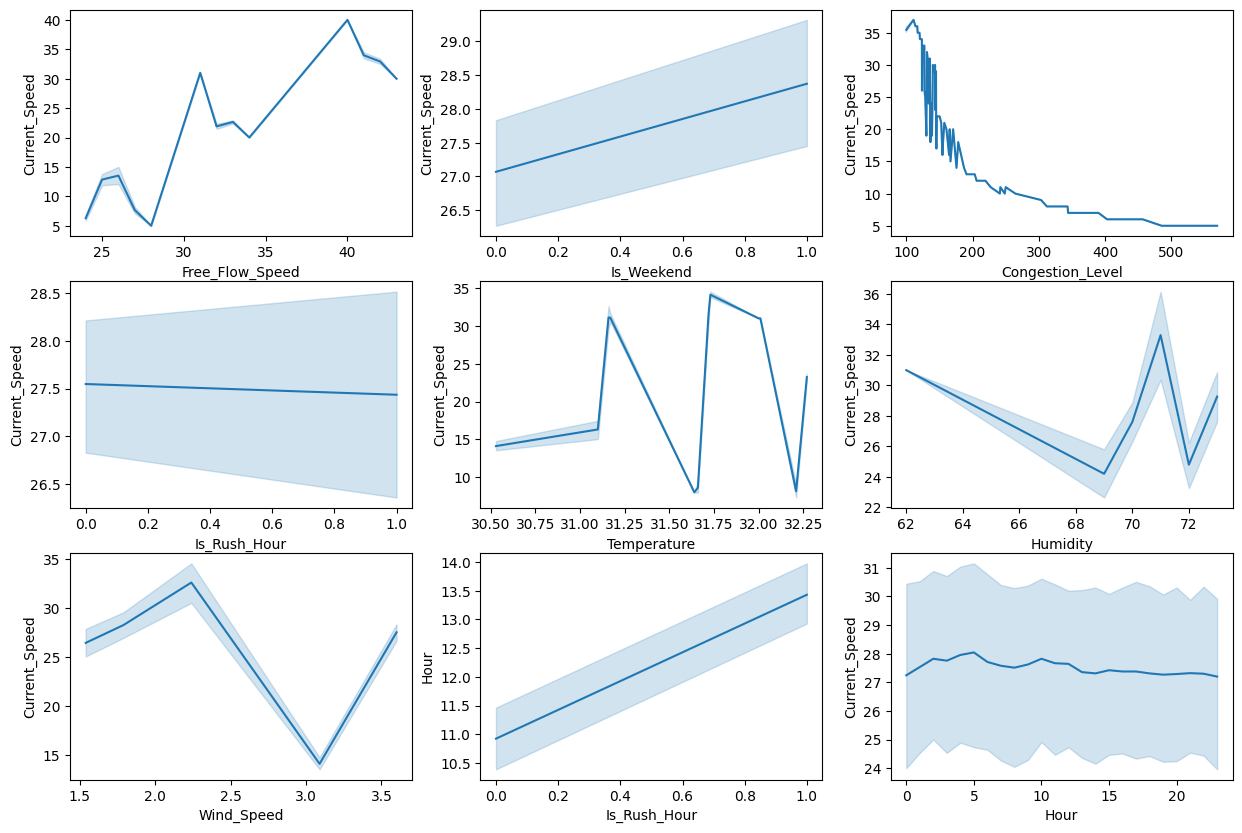

In [18]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
sns.lineplot(data=merged_df, x='Free_Flow_Speed', y='Current_Speed')

plt.subplot(3, 3, 2)
sns.lineplot(data=merged_df, x='Is_Weekend', y='Current_Speed')

plt.subplot(3,3 , 3)    
sns.lineplot(data=merged_df, x='Congestion_Level', y='Current_Speed')

plt.subplot(3, 3, 4)
sns.lineplot(data=merged_df, x='Is_Rush_Hour', y='Current_Speed')

plt.subplot(3, 3, 5)
sns.lineplot(data=merged_df, x='Temperature', y='Current_Speed')

plt.subplot(3, 3, 6)
sns.lineplot(data=merged_df, x='Humidity', y='Current_Speed')

plt.subplot(3, 3, 7)
sns.lineplot(data=merged_df, x='Wind_Speed', y='Current_Speed')

plt.subplot(3, 3, 8)
sns.lineplot(data=merged_df, x='Is_Rush_Hour', y='Hour')

plt.subplot(3, 3, 9)
sns.lineplot(data=merged_df, x='Hour', y='Current_Speed')   

plt.show()


Current_Speed       1.000000
Free_Flow_Speed     0.817374
Temperature         0.099907
Is_Weekend          0.059679
Day_of_Week         0.028254
Wind_Speed         -0.000128
Is_Rush_Hour       -0.004923
Hour               -0.015372
Humidity           -0.131811
Congestion_Level   -0.819889
Name: Current_Speed, dtype: float64


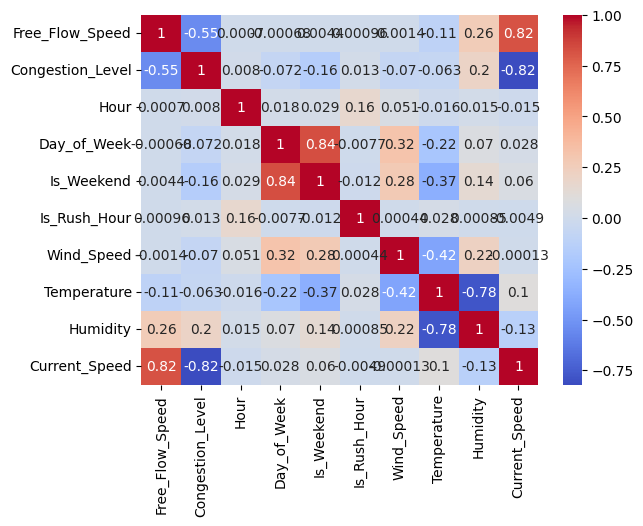

In [37]:
features = [
    'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature','Humidity'
]
target = 'Current_Speed'
corr_matrix = merged_df[features + [target]].corr()
print(corr_matrix['Current_Speed'].sort_values(ascending=False))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


- Strong positive correlation:

Current_Speed ~ Free_Flow_Speed (≈ 0.82) → makes sense, higher free-flow speed → higher actual speed.

- Strong negative correlation:

Current_Speed ~ Congestion_Level (≈ –0.82) → higher congestion → lower actual speed.

- Weak correlations:

Time-based features (Hour, Day_of_Week, Is_Weekend, Is_Rush_Hour) are basically noise in this dataset — they don’t add much predictive power (correlation ~0).

👉 Interpretation: Your data analysis shows that traffic speed is almost entirely explained by free-flow speed and congestion level, at least in this 147-hour dataset. Weather/time features don’t matter much yet (but may become relevant with larger/seasonal data).

### IV. Machine Learning Models 
1. KNN Regression
2. Linear Regression    
3. Decision Tree Regression
4. SVR Regression

In [38]:
# 1. Prepare data for machine learning
# Define features and target variable
features = [
    'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature', 'Rainfall','Humidity'
]
target = 'Current_Speed'

X = merged_df[features] 
y = merged_df[target]   

# 2. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"\nTraining samples: {len(X_train)}, Testing samples: {len(X_test)}")

# 3. Scale features for KNN 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# MODEL 1: K-Nearest Neighbors Regression
print("\nTraining KNN Regression model...")
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)  
knn_predictions = knn_model.predict(X_test_scaled)  
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_mse = mean_squared_error(y_test, knn_predictions)   
knn_r2 = r2_score(y_test, knn_predictions)

print(f"KNN MAE: {knn_mae}, MQE: {knn_mse} R²: {knn_r2}")


# MODEL 2: Linear Regression
print("\nTraining Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_mse = mean_squared_error(y_test, lr_predictions) 
lr_r2 = r2_score(y_test, lr_predictions)
print(f"Linear Regression MAE: {lr_mae}, MQE: {lr_mse} R²: {lr_r2}")

# MODEL 3: Decision Tree Regression
print("\nTraining Decision Tree Regression model...")
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
dt_predictions = dt_model.predict(X_test)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)
print(f"Decision Tree MAE: {dt_mae}, MQE: {dt_mse} R²: {dt_r2}")

# MODEL 4: SVR Regression
print("\nTraining SVM Regression model..."  )
svm_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svm_model.fit(X_train, y_train)
svm_predictions = svm_model.predict(X_test)
svm_mae = mean_absolute_error(y_test, svm_predictions)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_r2 = r2_score(y_test, svm_predictions)
print(f"SVM MAE: {svm_mae}, MQE: {svm_mse} R²: {svm_r2}")

# Compare model performances
comparison_df = pd.DataFrame({
    'Model': ['KNN Regression', 'Linear Regression', 'Decision Tree Regression', 'SVM'],
    'MAE': [knn_mae, lr_mae, dt_mae, svm_mae],
    'MSE': [knn_mse, lr_mse, dt_mse, svm_mse],
    'R²': [knn_r2, lr_r2, dt_r2, svm_r2]
})  
print("="*50)
print(comparison_df.to_string(index=False))




Training samples: 766, Testing samples: 329

Training KNN Regression model...
KNN MAE: 1.6468085106382977, MQE: 5.459817629179332 R²: 0.9485638624164369

Training Linear Regression model...
Linear Regression MAE: 2.6312971092470594, MQE: 10.702216133128667 R²: 0.8991759983830488

Training Decision Tree Regression model...
Decision Tree MAE: 0.2150190400531314, MQE: 0.2655271927765673 R²: 0.997498507432402

Training SVM Regression model...
SVM MAE: 0.8900157945854628, MQE: 4.548274711584951 R²: 0.9571513739611686
                   Model      MAE       MSE       R²
          KNN Regression 1.646809  5.459818 0.948564
       Linear Regression 2.631297 10.702216 0.899176
Decision Tree Regression 0.215019  0.265527 0.997499
                     SVM 0.890016  4.548275 0.957151


- Decision Tree Regression is the best model overall with lowest MAE (0.215), lowest MSE (0.265), and highest R-squared (0.9975) but may be overfitting.  
- SVM Regression is the next best choice, offering strong performance with less risk of overfitting.  


## Cross-Validation + Hyperparameter 

- Cross-validation avoids a particular train-test split, and produces a more realistic overall model score. 

In [60]:
# Define the number of folds for cross-validation
# the higher the R-squared, the better the model fits your data.​
num_folds= 5
cv = KFold(n_splits=5,shuffle=True, random_state=42 )

# Model 1: Linear Regression 
lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, X, y, cv=cv, scoring='r2')
print("-- Linear Regression (R²):")
for i, score in enumerate(lin_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")
print(f"Mean R²: {lin_scores.mean()*100:.2f}%\n")

# Model 2: SVR (with GridSearch) 
svr = SVR(kernel='rbf')
param_grid = {'C':[1, 10, 100], 'gamma':['scale', 0.1]}
svr_grid = GridSearchCV(svr, param_grid=param_grid, cv=cv, scoring='r2')
svr_grid.fit(X, y)
print("-- SVR (R²):")
print("Best Params:", svr_grid.best_params_)
best_svr = svr_grid.best_estimator_
svr_scores = cross_val_score(best_svr, X, y, cv=cv, scoring='r2')
for i, score in enumerate(svr_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")
print(f"Best CV R²: {svr_grid.best_score_*100:.2f}%\n")

# Model 3: Decision Tree Regressor 
dt = DecisionTreeRegressor(random_state=42)
params = {'max_depth':[3, 5, 7, 10, None],
          'min_samples_split':[2, 5, 10]}
grid = GridSearchCV(dt, params, cv=cv, scoring='r2')
grid.fit(X, y)
print("-- Decision Tree (R²):")
print("Best Params:", grid.best_params_)
best_dt = grid.best_estimator_
dt_scores = cross_val_score(best_dt, X, y, cv=cv, scoring='r2')
for i, score in enumerate(dt_scores, 1):
    print(f"  Fold {i}: {score*100:.2f}%")
print(f"Best CV R²: {grid.best_score_*100:.2f}%\n")

-- Linear Regression (R²):
  Fold 1: 2.23%
  Fold 2: -0.74%
  Fold 3: 2.78%
  Fold 4: 1.56%
  Fold 5: 2.38%
Mean R²: 1.64%

-- SVR (R²):
Best Params: {'C': 100, 'gamma': 'scale'}
  Fold 1: -0.02%
  Fold 2: 1.53%
  Fold 3: -5.50%
  Fold 4: -10.40%
  Fold 5: -0.38%
Best CV R²: -2.96%

-- Decision Tree (R²):
Best Params: {'max_depth': 5, 'min_samples_split': 2}
  Fold 1: 67.18%
  Fold 2: 69.36%
  Fold 3: 64.87%
  Fold 4: 70.07%
  Fold 5: 70.24%
Best CV R²: 68.34%



## Feature Importance and Permutation Importance

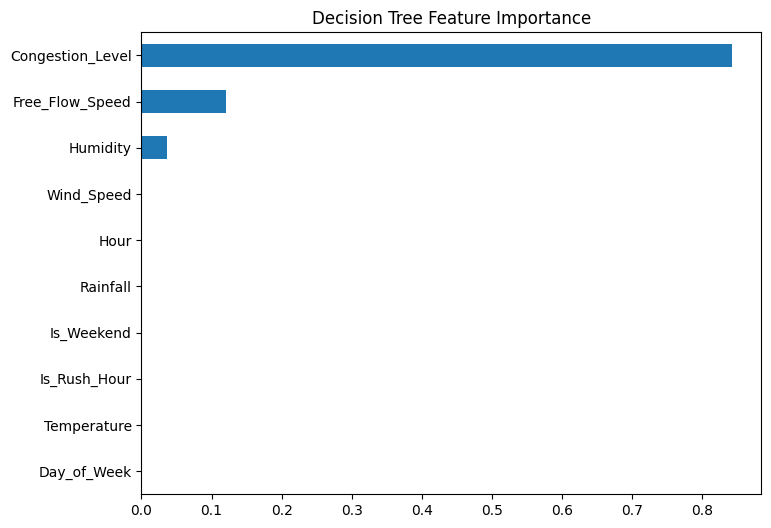

In [22]:
dt_model = grid.best_estimator_
importances = pd.Series(dt_model.feature_importances_, index=X_train.columns)
importances.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Decision Tree Feature Importance")
plt.show()

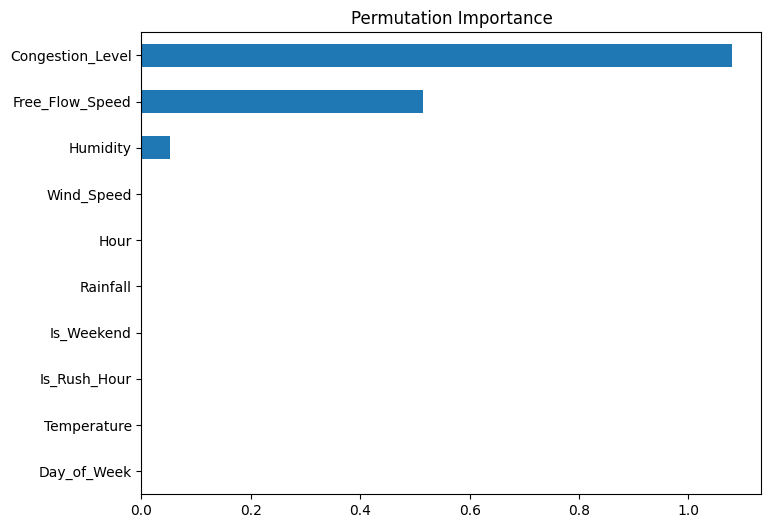

Congestion_Level    1.079466
Free_Flow_Speed     0.513780
Humidity            0.051789
Wind_Speed          0.000069
Hour                0.000037
Day_of_Week         0.000000
Temperature         0.000000
Rainfall            0.000000
Is_Rush_Hour        0.000000
Is_Weekend          0.000000
dtype: float64


In [23]:

result = permutation_importance(dt_model, X_test, y_test, n_repeats=10, random_state=42)

perm_importances = pd.Series(result.importances_mean, index=X_test.columns)
perm_importances = perm_importances.sort_values(ascending=True)

plt.figure(figsize=(8,6))
perm_importances.plot(kind='barh')
plt.title("Permutation Importance")
plt.show()

print(perm_importances.sort_values(ascending=False))


In [24]:
corr = merged_df[features + [target]].corr()
print(corr[target].sort_values(ascending=False))


Current_Speed       1.000000
Free_Flow_Speed     0.817374
Temperature         0.099907
Is_Weekend          0.059679
Day_of_Week         0.028254
Wind_Speed         -0.000128
Is_Rush_Hour       -0.004923
Hour               -0.015372
Humidity           -0.131811
Congestion_Level   -0.819889
Rainfall                 NaN
Name: Current_Speed, dtype: float64


In [62]:
# Logistic Regression 
log_reg = LogisticRegression(max_iter=200)
log_reg.fit(X_train, y_train)
log_acc = accuracy_score(y_test, log_reg.predict(X_test))   

# SVM Regression 
svm_clf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)   
svm_clf.fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)
svm_mae = mean_absolute_error(y_test, svm_pred)
svm_mse = mean_squared_error(y_test, svm_pred)
svm_r2 = r2_score(y_test, svm_pred)

# SGDClassifier as Logistic Regression
sgd_log = SGDClassifier(loss="log_loss", max_iter=1000, random_state=42)
sgd_log.fit(X_train, y_train)
sgd_log_acc = accuracy_score(y_test, sgd_log.predict(X_test))

# SGDClassifier as SVM (hinge loss)
sgd_svm = SGDClassifier(loss="hinge", max_iter=1000, random_state=42)
sgd_svm.fit(X_train, y_train)
sgd_svm_acc = accuracy_score(y_test, sgd_svm.predict(X_test))

print("Logistic Regression Accuracy:", log_acc)
print("SVM Regression MAE:", svm_mae)
print("SVM Regression MSE:", svm_mse)
print("SVM Regression R²:", svm_r2)
print("SGDClassifier (Logistic) Accuracy:", sgd_log_acc)


Logistic Regression Accuracy: 0.4063926940639269
SVM Regression MAE: 9.59779304005097
SVM Regression MSE: 153.32229754846318
SVM Regression R²: -0.4011821340376396
SGDClassifier (Logistic) Accuracy: 0.4337899543378995


c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Models (Predict classes instead of continuous speeds)

Logistic Regression Accuracy: 1.0 → perfect classification on test set.

SGDClassifier (Logistic) Accuracy: 0.6 → worse because SGD is approximate and needs more data/tuning.

Logistic Regression (binned) Accuracy: 1.0 → when speeds were grouped into bins, still perfect.

SGDClassifier (Logistic, binned) Accuracy: 0.8 → improved after binning.

SGDClassifier (SVM hinge, binned) Accuracy: 0.8 → hinge-loss SVM also worked decently.

👉 Interpretation:

Logistic Regression is very strong here because the dataset is small and clean.

SGDClassifier is less accurate but more scalable (for large datasets).

SVM hinge loss behaves like a linear SVM, good but not perfect.


In [57]:
## Predict speed with exact lodation and timestamp 

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'SVM': SVR(kernel='rbf')
}

model_list ={}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    model_list[name] = {'MSE': mse, 'MAE': mae}

loc_name = 'District_1'
loc_timestamp = pd.Timestamp(datetime(2025, 9, 29, 9, 0), tz='Asia/Ho_Chi_Minh') 

df_loc = merged_df[merged_df['Location'] == loc_name].copy()
if df_loc.empty:
    print(f"\nError: No data for location '{loc_name}'.")
else: 
    df_loc['time_diff'] = (df_loc['Timestamp'] - loc_timestamp).abs() # using abs() for making sure the result is positive (not -15min)

    X_pred = pd.DataFrame([df_loc.loc[df_loc['time_diff'].idxmin(), feature_cols].to_dict()])
    X_pred = X_pred.fillna(0)

    print(f"\nPredicted Speeds for {loc_name} at {loc_timestamp}:")
    for name, model in models.items():
        predicted_speed = model.predict(X_pred)[0]
        print(f"{name}: {predicted_speed:.2f} km/h")





Predicted Speeds for District_1 at 2025-09-29 09:00:00+07:00:
Linear Regression: 25.20 km/h
Decision Tree: 17.00 km/h
SVM: 29.10 km/h


In [26]:
import numpy as np
import pandas as pd
import math
from math import radians, sin, cos, asin, sqrt

# def haversine_km(lat1, lon1, lat2, lon2):
#     R = 6371.0
#     dlat = radians(lat2 - lat1)
#     dlon = radians(lon2 - lon1)
#     a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
#     return 2 * R * asin(sqrt(a))

# calculate great-circle distances between the two points - using the Haversine formula

def haversine(lat1, lon1, lat2, lon2):
    
    # distance between latitudes
    # and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0

    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0

    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) + 
         pow(math.sin(dLon / 2), 2) * 
             math.cos(lat1) * math.cos(lat2))
    r = 6371.0
    return  2 * math.asin(math.sqrt(a)) * r

# => distance: between origin and destination to turn speed -> time

def minutes_from_speed(distance_km, speed_kmh, min_speed_kmh=3.0, calibration=1.0):
    # time = distance / speed
    eff_speed = max(float(speed_kmh), min_speed_kmh)
    minutes = (distance_km / eff_speed) * 60.0
    return minutes * calibration

# convert distance & speed into minutes =>  calibration: a safety multiplier (+10%) for junctions, signals, human behavior

def get_features_for(loc_name, when_ts, merged_df, feature_cols):
    df_loc = merged_df[merged_df['Location'] == loc_name].copy()
    if df_loc.empty:
        raise ValueError(f"No data for location '{loc_name}'.")
    idx = (df_loc['Timestamp'] - when_ts).abs().sort_values().index[0]
    row = df_loc.loc[idx]
    X_row = pd.DataFrame([row[feature_cols].to_dict()])
    return X_row, row


In [27]:
def predict_speed_kmh(model, loc_name, when_ts, merged_df, feature_cols):
    X, _ = get_features_for(loc_name, when_ts, merged_df, feature_cols)
    y_hat = model.predict(X)
    return float(y_hat[0]), X


In [28]:
def estimate_travel_time_dt(
    model, origin_name, dest_name, when_ts, merged_df, feature_cols,
    locations_dict, route_factor=1.30, time_calibration=1.10
):
    # Distances
    o = locations_dict[origin_name]; 
    d = locations_dict[dest_name]
    straight_km = haversine(o['lat'], o['lon'], d['lat'], d['lon'])
    route_km = straight_km * route_factor
    # 1.30 -> assume roads are ~30% longer than straight line

    # Predicted speeds
    v_o, Xo = predict_speed_kmh(model, origin_name, when_ts, merged_df, feature_cols)
    v_d, Xd = predict_speed_kmh(model, dest_name, when_ts, merged_df, feature_cols)
    v_avg = (v_o + v_d) / 2.0
    # predict speed at origin and destination
    # average the two speeds: Alternatives: min(v_o, v_d) for conservative estimates; or add a midpoint point later.

    # ETA: estimated time of arrival 
    eta_minutes = minutes_from_speed(route_km, v_avg, min_speed_kmh=3.0, calibration=time_calibration)
    

    result = {
        "origin": origin_name,
        "destination": dest_name,
        "timestamp_used": when_ts,
        "straight_distance_km": round(straight_km, 3),
        "estimated_route_km": round(route_km, 3),
        "pred_speed_origin_kmh": round(v_o, 2),
        "pred_speed_dest_kmh": round(v_d, 2),
        "avg_speed_kmh": round(v_avg, 2),
        "eta_minutes": round(eta_minutes, 1),
    }

    # Add global feature importance
    importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
    result["global_feature_importance"] = importances.round(3).to_dict()

    return result


In [32]:
best_model = grid.best_estimator_   # replace with dt_model if you didn’t tune

hcmc_tz = timezone("Asia/Ho_Chi_Minh")
when = pd.Timestamp("2025-09-30 17:00:00", tz=hcmc_tz)

feature_cols = [   'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature', 'Rainfall','Humidity']

res_dt = estimate_travel_time_dt(
    model=best_model,
    origin_name="District_1",
    dest_name="Tan_Son_Nhat",
    when_ts=when,
    merged_df=merged_df,
    feature_cols=feature_cols,
    locations_dict=hcmc_locations,
    route_factor=1.30,
    time_calibration=1.10
)
res_dt


{'origin': 'District_1',
 'destination': 'Tan_Son_Nhat',
 'timestamp_used': Timestamp('2025-09-30 17:00:00+0700', tz='Asia/Ho_Chi_Minh'),
 'straight_distance_km': 7.133,
 'estimated_route_km': 9.272,
 'pred_speed_origin_kmh': 16.0,
 'pred_speed_dest_kmh': 31.0,
 'avg_speed_kmh': 23.5,
 'eta_minutes': 26.0,
 'global_feature_importance': {'Congestion_Level': 0.843,
  'Free_Flow_Speed': 0.121,
  'Humidity': 0.037,
  'Wind_Speed': 0.0,
  'Hour': 0.0,
  'Day_of_Week': 0.0,
  'Is_Rush_Hour': 0.0,
  'Is_Weekend': 0.0,
  'Temperature': 0.0,
  'Rainfall': 0.0}}